In [1]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_dist.ipynb

# Hypothesis #1

Research Question:
If the distribution of ages in training and test sets is causing the poor generalizability of both complex and simple models, then both simple and complex models trained on datasets with similar age distributions to our original training dataset will perform worse than chance when tested on samples from new datasets that mimic the age distribution of our original test dataset.

## Setup

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [3]:
# project directory
project_dir = Path('/data/NNDSP')

# NNDSP data directories
nndsp_bids_dir = Path('/data/NNDSP/bids_2017_07_14_generic')
nndsp_fs_dir = Path('/data/NNDSP/derivatives/fs5.3_subj')
nndsp_bar_dir = Path('/data/NNDSP/derivatives/bar_subj')
nndsp_pheno_file = Path('/data/NNDSP/anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

# HCP data directories
hcp_bids_dir = Path('/data/HCP/HCP_900/s3/hcp')
hcp_fs_dir = Path('/data/NNDSP/derivatives/fs_hcp_subj')
hcp_bar_dir = Path('/data/NNDSP/derivatives/bar_hcp_subj')
hcp_pheno_file = Path('/data/NNDSP/nino/HCP_ages.csv')

# NKI data directories
nki_bids_dir = Path('/data/NNDSP/anal/NKI')
nki_fs_dir = Path('/data/NNDSP/derivatives/fs_nki_subj')
nki_bar_dir = Path('/data/NNDSP/derivatives/bar_nki_subj')
nki_pheno_file = Path('/data/NNDSP/anal/analysis_notebooks/phenotype_files/participants.tsv')

# CoRR data directories
corr_bids_dir = Path('/data/DSST/CoRR/bids_corr')
corr_fs_dir = Path('/data/DSST/CoRR/fs_corr')
corr_bar_dir = Path('/data/DSST/CoRR/bar_corr/baracus')
corr_pheno_file = Path('/data/DSST/CoRR/phenotype_files/corr_ages.csv')

# SALD data directories
sald_bids_dir = Path('/data/DSST/SALD/bids_sald')
sald_fs_dir = Path('/data/DSST/SALD/fs_sald')
sald_bar_dir = Path('/data/DSST/SALD/bar_sald/baracus')
sald_pheno_file = Path('/data/DSST/SALD/phenotype_files/sub_information.xlsx')

In [7]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_setup.ipynb

## NNDSP Subject Data

In [8]:
# merge the subjects that we have fs and add subject number
df_nndsp = nndsp_subjectdata(nndsp_fs_dir, nndsp_pheno_file)
df_nndsp.head()

,subj_paths,subject,MRN,nuclear_fam_id,Sex,age
53,/data/NNDSP/derivatives/fs5.3_subj/sub-0102,102,4569829,10392,Male,28.542094
116,/data/NNDSP/derivatives/fs5.3_subj/sub-0114,114,4578673,10391,Male,25.957563
330,/data/NNDSP/derivatives/fs5.3_subj/sub-0126,126,4572324,10381,Male,6.015058
291,/data/NNDSP/derivatives/fs5.3_subj/sub-0127,127,4572166,10381,Male,7.926078
139,/data/NNDSP/derivatives/fs5.3_subj/sub-0133,133,4601373,10208,Female,22.168378


## HCP Subject Data

In [9]:
# merge the subjects that we have fs and add subject number
df_hcp = hcp_subjectdata(hcp_fs_dir, hcp_pheno_file)
df_hcp.head()

,subj_paths,subject,age,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,...,SSAGA_Times_Used_Illicits,SSAGA_Times_Used_Cocaine,SSAGA_Times_Used_Hallucinogens,SSAGA_Times_Used_Opiates,SSAGA_Times_Used_Sedatives,SSAGA_Times_Used_Stimulants,SSAGA_Mj_Use,SSAGA_Mj_Ab_Dep,SSAGA_Mj_Age_1st_Use,SSAGA_Mj_Times_Used
339,/data/NNDSP/derivatives/fs_hcp_subj/sub-100206,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
873,/data/NNDSP/derivatives/fs_hcp_subj/sub-100307,100307,27,True,NotMZ,MZ,51488_81352,51488,81352,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0
579,/data/NNDSP/derivatives/fs_hcp_subj/sub-100408,100408,33,True,MZ,MZ,51730_81594,51730,81594,NaN,...,4.0,5.0,5.0,5.0,0.0,0.0,1.0,1.0,2.0,4.0
206,/data/NNDSP/derivatives/fs_hcp_subj/sub-100610,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
325,/data/NNDSP/derivatives/fs_hcp_subj/sub-101006,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,5.0


## NKI Subject Data

In [10]:
# merge the subjects that we have fs and add subject number
df_nki = nki_subjectdata(nki_fs_dir, nki_pheno_file)
df_nki.head()

,subj_paths,subject,age,sex,handedness
1269,/data/NNDSP/derivatives/fs_nki_subj/sub-A00008326,A00008326,59.0,FEMALE,RIGHT
548,/data/NNDSP/derivatives/fs_nki_subj/sub-A00008399,A00008399,23.0,MALE,RIGHT
820,/data/NNDSP/derivatives/fs_nki_subj/sub-A00010893,A00010893,28.0,MALE,RIGHT
1125,/data/NNDSP/derivatives/fs_nki_subj/sub-A00013809,A00013809,61.0,FEMALE,RIGHT
822,/data/NNDSP/derivatives/fs_nki_subj/sub-A00018030,A00018030,11.0,FEMALE,LEFT


## CoRR Subject Data

In [11]:
# merge the subjects that we have fs and add subject number
df_corr = corr_subjectdata(corr_fs_dir, corr_pheno_file)
df_corr.head()

,subj_paths,subject,Unnamed: 0,age,SEX
1816,/data/DSST/CoRR/fs_corr/sub-0003001,3001,0,25,2
4159,/data/DSST/CoRR/fs_corr/sub-0003002,3002,2,23,1
4427,/data/DSST/CoRR/fs_corr/sub-0003004,3004,4,31,2
4077,/data/DSST/CoRR/fs_corr/sub-0003006,3006,6,23,1
131,/data/DSST/CoRR/fs_corr/sub-0003007,3007,8,43,2


## SALD Subject Data

In [13]:
# complete once we have SALD FS files
df_sald = sald_subjectdata(sald_fs_dir, sald_pheno_file)
df_sald.head()

,subj_paths,subject,Sex,age,Sex.1,Edinburgh Handedness Inventory (EHI),FunImg,T1Img
98,/data/DSST/SALD/fs_sald/sub-031274,31274,F,72,1,100.0,1,1
28,/data/DSST/SALD/fs_sald/sub-031277,31277,F,60,1,100.0,1,1
95,/data/DSST/SALD/fs_sald/sub-031279,31279,M,62,2,100.0,1,1
29,/data/DSST/SALD/fs_sald/sub-031281,31281,F,65,1,NaN,1,1
108,/data/DSST/SALD/fs_sald/sub-031285,31285,M,54,2,NaN,1,1


## Sample NKI:NNDSP

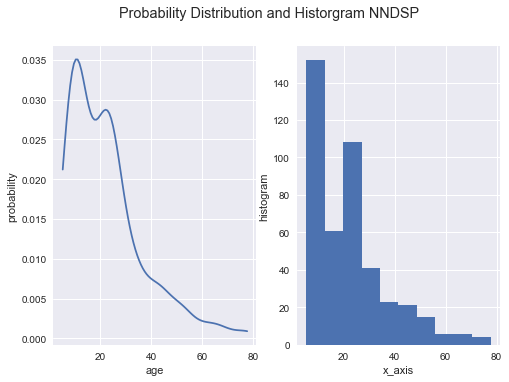

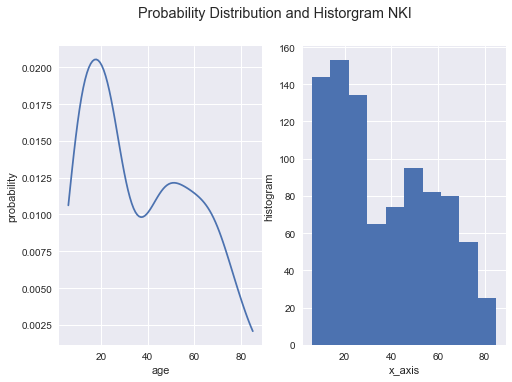

New Length:  329  with Precision:  1.0
Actual Length:  316


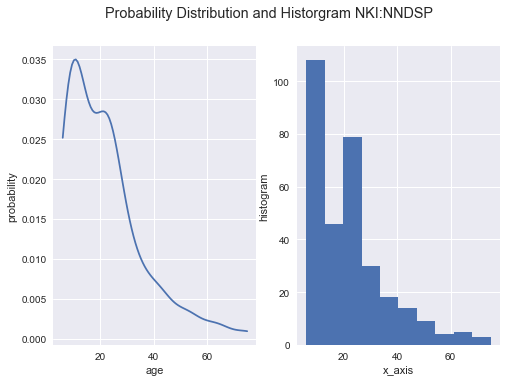

stats:  Ks_2sampResult(statistic=0.056462358427714854, pvalue=0.59053597735808294)


In [20]:
df_nki_nndsp = sample(df_nki, df_nndsp, title_to='NKI', title_from='NNDSP')
df_nki_nndsp = df_nki_nndsp.sort_values(by='subject')

## Sample CoRR:NNDSP

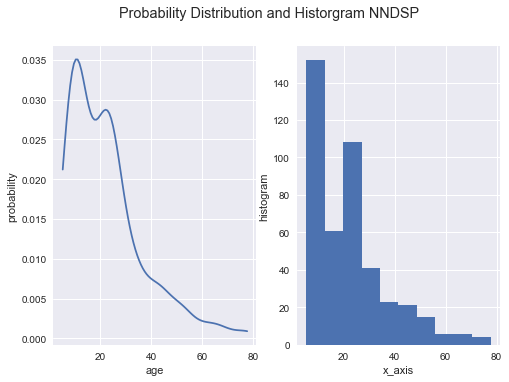

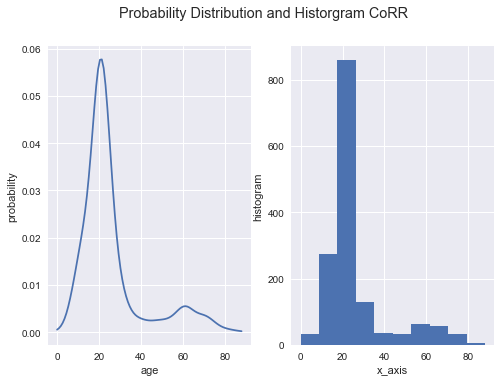

New Length:  187  with Precision:  1.0
Actual Length:  172


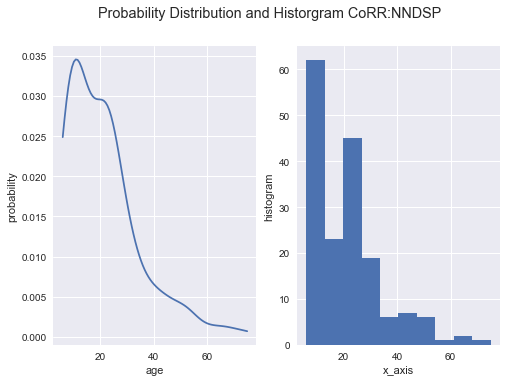

stats:  Ks_2sampResult(statistic=0.06823745410036719, pvalue=0.59871984735369399)


In [22]:
df_corr_nndsp = sample(df_corr, df_nndsp, title_to='CoRR', title_from='NNDSP', bucket_size=3)
df_corr_nndsp = df_corr_nndsp.sort_values(by='subject')

## Sample SALD:NNDSP

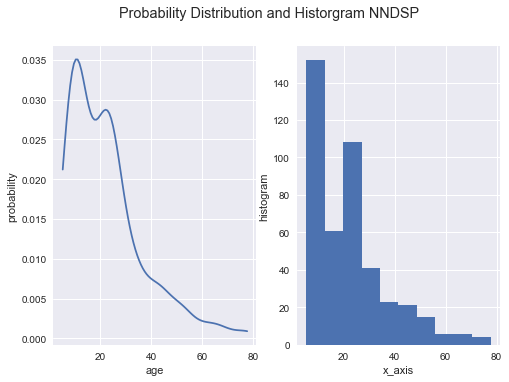

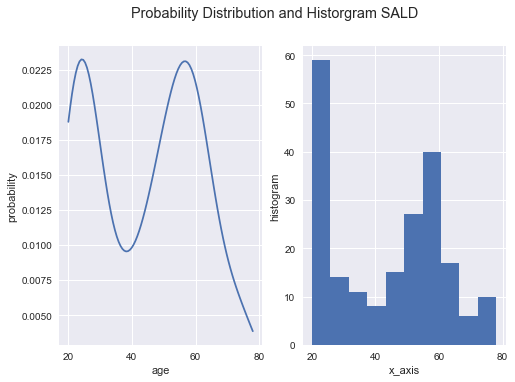

New Length:  128.27650835937249  with Precision:  0.1
Actual Length:  54


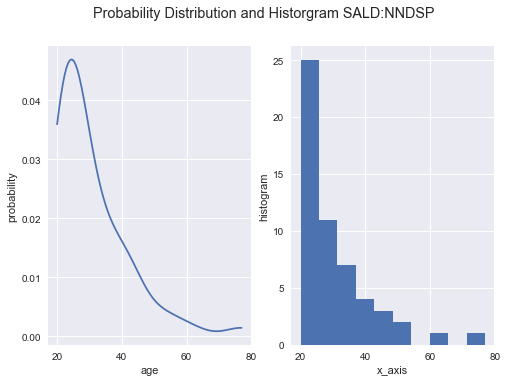

stats:  Ks_2sampResult(statistic=0.49864395287736252, pvalue=3.238828470591827e-11)


In [24]:
df_sald_nndsp = sample(df_sald, df_nndsp, title_to='SALD', title_from='NNDSP', bucket_size=3)
df_sald_nndsp = df_sald_nndsp.sort_values(by='subject')

## Sample NKI:HCP

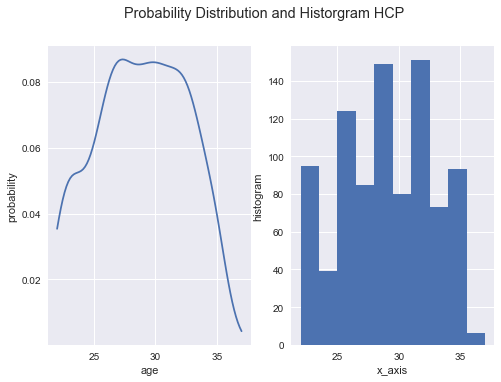

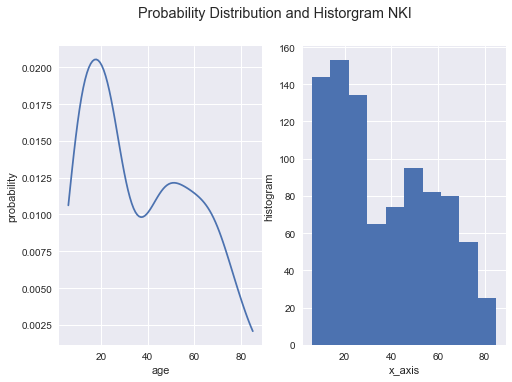

New Length:  94  with Precision:  1.0
Actual Length:  89


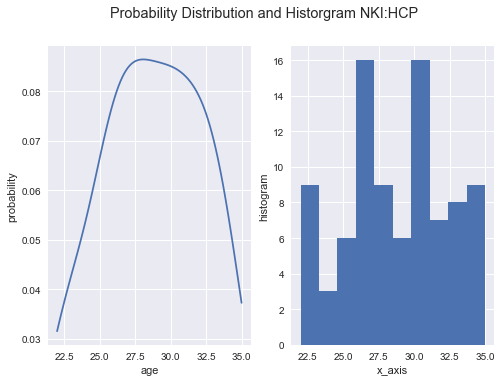

stats:  Ks_2sampResult(statistic=0.018341598141987325, pvalue=0.99999999999999989)


In [25]:
df_nki_hcp = sample(df_nki, df_hcp, title_to='NKI', title_from='HCP', bucket_size=2)
df_nki_hcp = df_nki_hcp.sort_values(by='subject')

## Sample CoRR:HCP

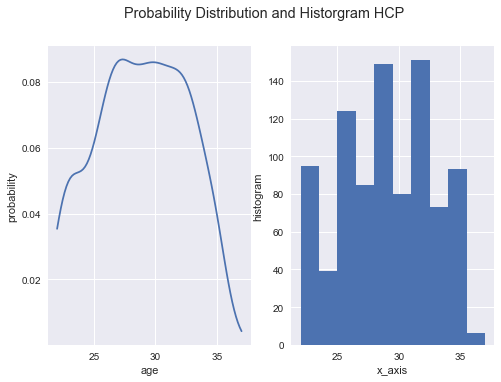

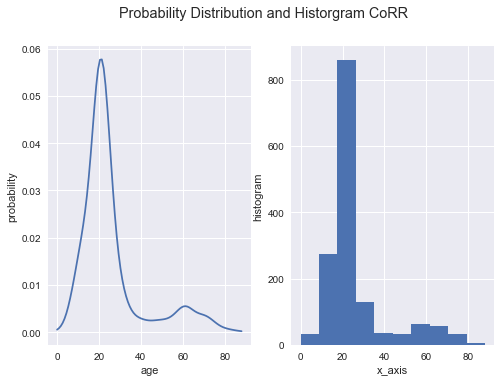

New Length:  102  with Precision:  1.0
Actual Length:  98


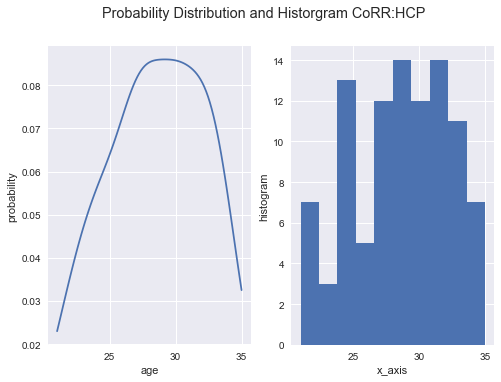

stats:  Ks_2sampResult(statistic=0.039185953711093457, pvalue=0.99903402021112231)


In [26]:
df_corr_hcp = sample(df_corr, df_hcp, title_to='CoRR', title_from='HCP', bucket_size=3)
df_corr_hcp = df_corr_hcp.sort_values(by='subject')

## Sample SALD:HCP

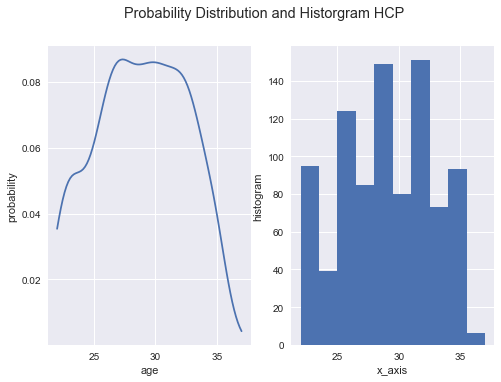

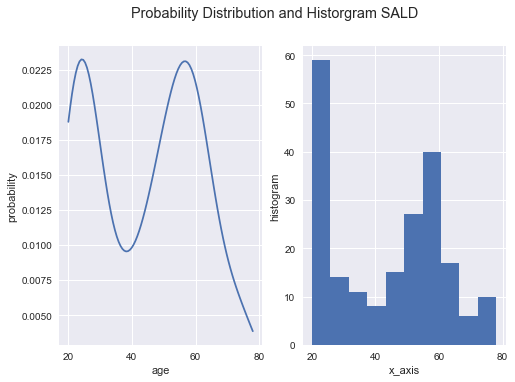

Actual Length:  35


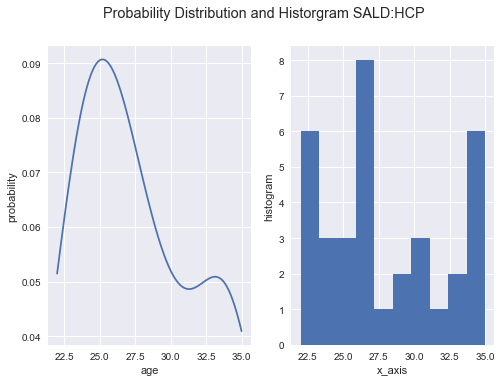

stats:  Ks_2sampResult(statistic=0.19744612928970473, pvalue=0.12737507186823213)


In [27]:
df_sald_hcp = sample(df_sald, df_hcp, title_to='SALD', title_from='HCP', bucket_size=2, new_len=65)
df_sald_hcp = df_sald_hcp.sort_values(by='subject')

# Train Test Hypothesis

In [38]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_models.ipynb

In [29]:
hcp_mae = {}
nki2hcp_mae = {}
corr2hcp_mae = {}
sald2hcp_mae = {}

## Train NNDSP

In [30]:
x, nndsp_features = subject_features([os.path.basename(s) for s in df_nndsp.subj_paths], nndsp_bar_dir)

In [39]:
scores_nndsp, nndsp_complex_train, nndsp_complex_test, nndsp_complex_pipes = complex_model(df_nndsp, nndsp_bar_dir, features = nndsp_features)


Cortical Thickness Pipeline
Mean Absolute Error (Train, thickness): 0.0986532727336
Mean Absolute Error (Test, thickness): 5.92468075601

Subcortival Volumes Pipeline
Mean Absolute Error (Train, aseg): 3.8902531334
Mean Absolute Error (Test, aseg): 5.12011473668

Cortical Surface Area Pipeline
Mean Absolute Error (Train, area): 0.10006225629
Mean Absolute Error (Test, area): 7.38692570119

Stacking predictions
Beginning Random Forest
Fitting stacking model
best max_depth: 3
Mean Absolute Error (Train): 3.58600575137
Mean Absolute Error (Test): 3.87507710301
                     r2     rpear    rpear2       mae     medae
aseg           0.765103  0.875584  0.766648  5.120115  3.620404
ct             0.700358  0.837323  0.701110  5.924681  4.714010
ca             0.599361  0.774943  0.600537  7.386926  6.302900
mean_pred      0.775598  0.892599  0.796733  5.085331  3.554793
pred_age_test  0.843499  0.918798  0.844190  3.875077  2.690522


In [40]:
nndsp_simple_train, nndsp_simple_test, nndsp_simple_pipe = simple_model(df_nndsp, nndsp_bar_dir, 
                                                                        model=True, 
                                                                        model_train = nndsp_complex_train, 
                                                                        model_test=nndsp_complex_test)

Finding Subjects
Extracting Features
431
Training Model
Mean Absolute Error (Train): 6.45408626147
Mean Absolute Error (Test): 6.86263127707


### Test on HCP

In [41]:
x, hcp_features = subject_features([os.path.basename(s) for s in df_hcp.subj_paths], hcp_bar_dir)

In [42]:
hcp_mae['Complex on NNDSP'] = complex_test(df_hcp, hcp_bar_dir, nndsp_complex_pipes, data='HCP', features=hcp_features)

895
895
Predicting from Pipelines
Mean Absolute Error (HCP thickness): 5.19168714415
Mean Absolute Error (HCP aseg): 5.15132443318
Mean Absolute Error (HCP area): 5.29501223792
Mean Absolute Error (HCP stack): 4.84234734103


In [35]:
hcp_mae['Simple on NNDSP'] = simple_test(df_hcp, hcp_bar_dir, nndsp_simple_pipe, data='HCP')

Finding Subjects
895
895
Extracting Features
895
Predicting Pipes
Mean Absolute Error (HCP simple): 10.4203486898


### Test on NKI:HCP

In [43]:
x, nki2hcp_features = subject_features([os.path.basename(s) for s in df_nki_hcp.subj_paths], nki_bar_dir)

In [44]:
nki2hcp_mae['Complex on NNDSP'] = complex_test(df_nki_hcp, nki_bar_dir, nndsp_complex_pipes, data='NKI:HCP', is_int=False, features=nki2hcp_features)

75
75
Predicting from Pipelines
Mean Absolute Error (NKI:HCP thickness): 6.36205861141
Mean Absolute Error (NKI:HCP aseg): 4.57860129733
Mean Absolute Error (NKI:HCP area): 5.48854794816
Mean Absolute Error (NKI:HCP stack): 6.27696443727


In [45]:
nki2hcp_mae['Simple on NNDSP'] = simple_test(df_nki_hcp, nki_bar_dir, nndsp_simple_pipe, data='NKI:HCP', is_int=False)

Finding Subjects
75
75
Extracting Features
75
Predicting Pipes
Mean Absolute Error (NKI:HCP simple): 5.65867547483


### Test on CORRS:HCP

In [46]:
df_corr_hcp.head()

,subj_paths,subject,Unnamed: 0,age,SEX
1816,/data/DSST/CoRR/fs_corr/sub-0003001,3001,0,25,2
4372,/data/DSST/CoRR/fs_corr/sub-0003009,3009,12,33,2
1687,/data/DSST/CoRR/fs_corr/sub-0003012,3012,18,33,2
4364,/data/DSST/CoRR/fs_corr/sub-0003013,3013,20,26,1
4161,/data/DSST/CoRR/fs_corr/sub-0003014,3014,22,28,2


In [47]:
x, corr2hcp_features = subject_features([os.path.basename(s) for s in df_corr_hcp.subj_paths], corr_bar_dir, 
                                        session='_ses-1')

In [48]:
corr2hcp_mae['Complex on NNDSP'] = complex_test(df_corr_hcp, corr_bar_dir, nndsp_complex_pipes, data='CoRR:HCP',
                                             features = corr2hcp_features, session = '_ses-1')

89
89
Predicting from Pipelines
Mean Absolute Error (CoRR:HCP thickness): 6.72405660234
Mean Absolute Error (CoRR:HCP aseg): 4.79258135344
Mean Absolute Error (CoRR:HCP area): 14.0328675782
Mean Absolute Error (CoRR:HCP stack): 5.53711971234


In [49]:
corr2hcp_mae['Simple on NNDSP'] = simple_test(df_corr_hcp, corr_bar_dir, nndsp_simple_pipe, 
                                              data='CoRR:HCP', session = '_ses-1')

Finding Subjects
89
89
Extracting Features
89
Predicting Pipes
Mean Absolute Error (CoRR:HCP simple): 6.5857400086


### Test on SALD:HCP

In [50]:
x, sald2hcp_features = subject_features([os.path.basename(s) for s in df_sald_hcp.subj_paths], sald_bar_dir)

In [51]:
sald2hcp_mae['Complex on NNDSP'] = complex_test(df_sald_hcp.drop_duplicates(), sald_bar_dir, nndsp_complex_pipes, data='SALD:HCP',
                                               features = sald2hcp_features)

35
35
Predicting from Pipelines
Mean Absolute Error (SALD:HCP thickness): 5.04404022096
Mean Absolute Error (SALD:HCP aseg): 4.68282695021
Mean Absolute Error (SALD:HCP area): 5.95896875769
Mean Absolute Error (SALD:HCP stack): 4.63681836659


In [52]:
sald2hcp_mae['Simple on NNDSP'] = simple_test(df_sald_hcp, sald_bar_dir, nndsp_simple_pipe, data='SALD:HCP')

Finding Subjects
35
35
Extracting Features
35
Predicting Pipes
Mean Absolute Error (SALD:HCP simple): 5.00761815912


## Train NKI:NNDSP

In [53]:
x, nki2nndsp_features = subject_features([os.path.basename(s) for s in df_nki_nndsp.subj_paths], nki_bar_dir)

In [54]:
scores_nki2nndsp, nki2nndsp_complex_train, nki2nndsp_complex_test, nki2nndsp_complex_pipes = complex_model(df_nki_nndsp, 
                                                                                                           nki_bar_dir, 
                                                                                                           is_int = False,
                                                                                                          features=nki2nndsp_features)


Cortical Thickness Pipeline
Mean Absolute Error (Train, thickness): 0.100002769764
Mean Absolute Error (Test, thickness): 6.87907394912

Subcortival Volumes Pipeline
Mean Absolute Error (Train, aseg): 4.72831780721
Mean Absolute Error (Test, aseg): 6.36698909698

Cortical Surface Area Pipeline
Mean Absolute Error (Train, area): 0.100018343388
Mean Absolute Error (Test, area): 8.07511262765

Stacking predictions
Beginning Random Forest
Fitting stacking model
best max_depth: 7
Mean Absolute Error (Train): 2.45907804355
Mean Absolute Error (Test): 5.04778419527
                     r2     rpear    rpear2       mae     medae
aseg           0.558596  0.761033  0.579172  6.366989  4.836508
ct             0.541737  0.763960  0.583635  6.879074  6.031705
ca             0.371314  0.649797  0.422236  8.075113  7.136779
mean_pred      0.690640  0.840901  0.707115  5.372103  4.586660
pred_age_test  0.690198  0.834485  0.696365  5.047784  3.670941


In [55]:
nki2nndsp_simple_train, nki2nndsp_simple_test, nki2nndsp_simple_pipe = simple_model(df_nki_nndsp, nki_bar_dir, 
                                                                        model=True, 
                                                                        model_train = nki2nndsp_complex_train, 
                                                                        model_test=nki2nndsp_complex_test,
                                                                                   is_int=False)

Finding Subjects
Extracting Features
261
Training Model
Mean Absolute Error (Train): 8.01358410451
Mean Absolute Error (Test): 7.28714873958


### Test on HCP

In [56]:
hcp_mae['Complex on NKI:NNDSP'] = complex_test(df_hcp, hcp_bar_dir, nki2nndsp_complex_pipes, data='HCP', is_int=True, features = hcp_features)

895
895
Predicting from Pipelines
Mean Absolute Error (HCP thickness): 8.47141973344
Mean Absolute Error (HCP aseg): 7.18575217881
Mean Absolute Error (HCP area): 5.37897763482
Mean Absolute Error (HCP stack): 7.85494577652


In [57]:
hcp_mae['Simple on NKI:NNDSP'] = simple_test(df_hcp, hcp_bar_dir, nki2nndsp_simple_pipe, data='HCP')

Finding Subjects
895
895
Extracting Features
895
Predicting Pipes
Mean Absolute Error (HCP simple): 12.2076947062


### Test on CoRR:HCP

In [58]:
corr2hcp_mae['Complex on NKI:NNDSP'] = complex_test(df_corr_hcp, corr_bar_dir, nki2nndsp_complex_pipes, data='CoRR:HCP',
        features = corr2hcp_features, session = '_ses-1')

89
89
Predicting from Pipelines
Mean Absolute Error (CoRR:HCP thickness): 5.71975419483
Mean Absolute Error (CoRR:HCP aseg): 6.14022861883
Mean Absolute Error (CoRR:HCP area): 14.8860467574
Mean Absolute Error (CoRR:HCP stack): 6.53725413682


In [59]:
corr2hcp_mae['Simple on NKI:NNDSP'] = simple_test(df_corr_hcp, corr_bar_dir, nki2nndsp_simple_pipe, data='CoRR:HCP',
                                                 session = '_ses-1')

Finding Subjects
89
89
Extracting Features
89
Predicting Pipes
Mean Absolute Error (CoRR:HCP simple): 7.40736443201


### Test on SALD:HCP

In [60]:
sald2hcp_mae['Complex on NKI:NNDSP'] = complex_test(df_sald_hcp, sald_bar_dir, nki2nndsp_complex_pipes, data='SALD:HCP',
                                                   features = sald2hcp_features)

35
35
Predicting from Pipelines
Mean Absolute Error (SALD:HCP thickness): 5.03355116404
Mean Absolute Error (SALD:HCP aseg): 6.27273080307
Mean Absolute Error (SALD:HCP area): 4.83596313126
Mean Absolute Error (SALD:HCP stack): 5.75483060465


In [62]:
sald2hcp_mae['Simple on NKI:NNDSP'] = simple_test(df_sald_hcp, sald_bar_dir, nki2nndsp_simple_pipe, data='SALD:HCP')

Finding Subjects
35
35
Extracting Features
35
Predicting Pipes
Mean Absolute Error (SALD:HCP simple): 6.22126127361


## Train on CoRR:NNDSP

In [63]:
scores_corr2nndsp, corr2nndsp_complex_train, corr2nndsp_complex_test, corr2nndsp_complex_pipes = complex_model(df_corr_nndsp, 
                                                                                                           corr_bar_dir, 
                                                                                                           is_int = True, 
                                                                                                            session = '_ses-1')

Finding Subjects
Extracting Features

Cortical Thickness Pipeline
Mean Absolute Error (Train, thickness): 0.0993765208558
Mean Absolute Error (Test, thickness): 5.26877475666

Subcortival Volumes Pipeline
Mean Absolute Error (Train, aseg): 2.66274443439
Mean Absolute Error (Test, aseg): 6.22425876107

Cortical Surface Area Pipeline
Mean Absolute Error (Train, area): 0.0995507438716
Mean Absolute Error (Test, area): 8.3490236876

Stacking predictions
Beginning Random Forest
Fitting stacking model
best max_depth: 3
Mean Absolute Error (Train): 3.2929529092
Mean Absolute Error (Test): 4.12745199626
                     r2     rpear    rpear2       mae     medae
aseg           0.597829  0.793908  0.630290  6.224259  5.350405
ct             0.691386  0.851436  0.724943  5.268775  4.226785
ca             0.339407  0.597731  0.357282  8.349024  7.532033
mean_pred      0.717927  0.869680  0.756343  5.115072  4.196437
pred_age_test  0.780771  0.886255  0.785447  4.127452  2.557450


In [64]:
corr2nndsp_simple_train, corr2nndsp_simple_test, corr2nndsp_simple_pipe = simple_model(df_corr_nndsp, corr_bar_dir, 
                                                                        model=True, 
                                                                        model_train = corr2nndsp_complex_train, 
                                                                        model_test=corr2nndsp_complex_test,
                                                                                   is_int=True, session = '_ses-1')

Finding Subjects
Extracting Features
166
Training Model
Mean Absolute Error (Train): 6.3350228027
Mean Absolute Error (Test): 6.78803771685


### Test on HCP

In [65]:
hcp_mae['Complex on CoRR:NNDSP'] = complex_test(df_hcp, hcp_bar_dir, corr2nndsp_complex_pipes, data='HCP', is_int=True, 
                                               features = hcp_features)

895
895
Predicting from Pipelines
Mean Absolute Error (HCP thickness): 6.67885819791
Mean Absolute Error (HCP aseg): 5.75521115306
Mean Absolute Error (HCP area): 6.71097237968
Mean Absolute Error (HCP stack): 6.03858619667


In [66]:
hcp_mae['Simple on CoRR:NNDSP'] = simple_test(df_hcp, hcp_bar_dir, corr2nndsp_simple_pipe, data='HCP')

Finding Subjects
895
895
Extracting Features
895
Predicting Pipes
Mean Absolute Error (HCP simple): 10.1034688318


### Test on NKI:HCP

In [67]:
nki2hcp_mae['Complex on CoRR:NNDSP'] = complex_test(df_nki_hcp, nki_bar_dir, corr2nndsp_complex_pipes, data='NKI:HCP', 
                                                    is_int=False, features = nki2hcp_features)

75
75
Predicting from Pipelines
Mean Absolute Error (NKI:HCP thickness): 4.3691800865
Mean Absolute Error (NKI:HCP aseg): 8.35693056994
Mean Absolute Error (NKI:HCP area): 6.78377525996
Mean Absolute Error (NKI:HCP stack): 7.17131368984


In [68]:
nki2hcp_mae['Simple on CoRR:NNDSP'] = simple_test(df_nki_hcp, nki_bar_dir, corr2nndsp_simple_pipe, data='NKI:HCP', is_int = False)

Finding Subjects
75
75
Extracting Features
75
Predicting Pipes
Mean Absolute Error (NKI:HCP simple): 6.23045732519


### Test on SALD:HCP

In [69]:
sald2hcp_mae['Complex on CoRR:NNDSP'] = complex_test(df_sald_hcp, sald_bar_dir, corr2nndsp_complex_pipes, 
                                                     data='SALD:HCP', is_int=True, features = sald2hcp_features)

35
35
Predicting from Pipelines
Mean Absolute Error (SALD:HCP thickness): 3.64677798028
Mean Absolute Error (SALD:HCP aseg): 7.34126214336
Mean Absolute Error (SALD:HCP area): 6.17854068094
Mean Absolute Error (SALD:HCP stack): 5.13237244524


In [70]:
sald2hcp_mae['Simple on CoRR:NNDSP'] = simple_test(df_sald_hcp, sald_bar_dir, corr2nndsp_simple_pipe, data='SALD:HCP', is_int = True)

Finding Subjects
35
35
Extracting Features
35
Predicting Pipes
Mean Absolute Error (SALD:HCP simple): 6.57960434139


# Statistical Tests

In [71]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_stats.ipynb

## Test on HCP

In [72]:
hcp_rand_ages = random_ages(df_hcp)

Picking Random Ages
0
100
200
300
400
500
600
700
800
900
Calculating Mean Absolute Errors


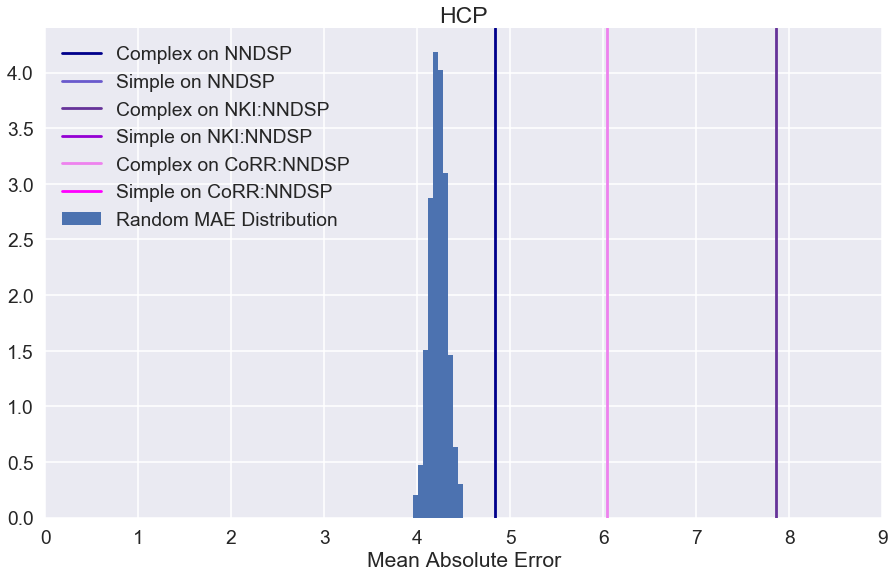

Percentile of  for Complex on NNDSP 100.0
Percentile of  for Simple on NNDSP 100.0
Percentile of  for Complex on NKI:NNDSP 100.0
Percentile of  for Simple on NKI:NNDSP 100.0
Percentile of  for Complex on CoRR:NNDSP 100.0
Percentile of  for Simple on CoRR:NNDSP 100.0


In [73]:
plot_rand_hist(hcp_rand_ages, hcp_mae, title='HCP', x_max = 9,
              set_context='poster', fig_tuple=(15, 9), legend=True)
get_percentile(hcp_rand_ages, hcp_mae)

## Test NKI:HCP

In [74]:
nki2hcp_rand_ages = random_ages(df_nki_hcp)

Picking Random Ages
0
100
200
300
400
500
600
700
800
900
Calculating Mean Absolute Errors


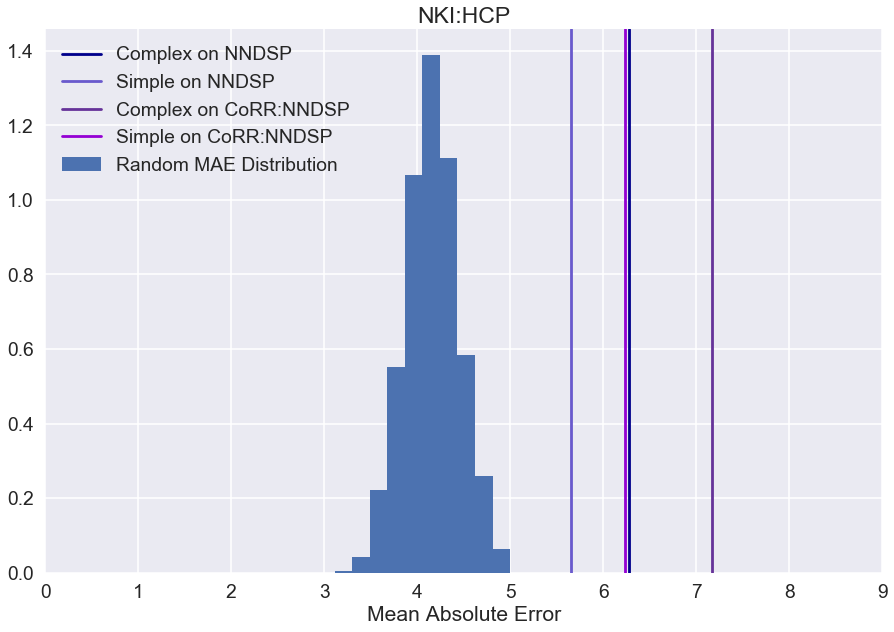

Percentile of  for Complex on NNDSP 100.0
Percentile of  for Simple on NNDSP 100.0
Percentile of  for Complex on CoRR:NNDSP 100.0
Percentile of  for Simple on CoRR:NNDSP 100.0


In [75]:
plot_rand_hist(nki2hcp_rand_ages, nki2hcp_mae, title='NKI:HCP', x_max = 9,
              set_context='poster', fig_tuple=(15, 10), legend=True)
get_percentile(nki2hcp_rand_ages, nki2hcp_mae)

## Test CoRR:HCP

In [76]:
corr2hcp_rand_ages = random_ages(df_corr_hcp)

Picking Random Ages
0
100
200
300
400
500
600
700
800
900
Calculating Mean Absolute Errors


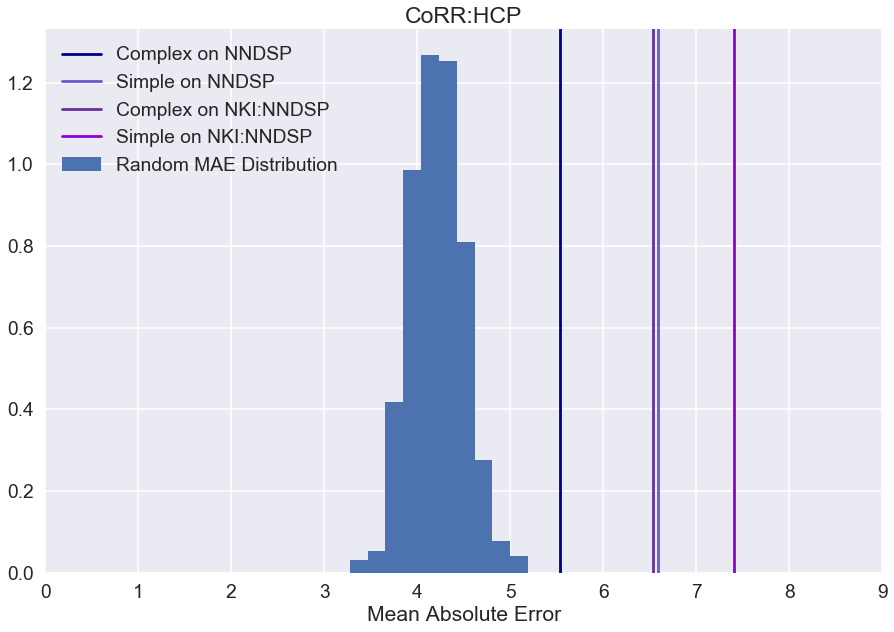

Percentile of  for Complex on NNDSP 100.0
Percentile of  for Simple on NNDSP 100.0
Percentile of  for Complex on NKI:NNDSP 100.0
Percentile of  for Simple on NKI:NNDSP 100.0


In [77]:
plot_rand_hist(corr2hcp_rand_ages, corr2hcp_mae, title='CoRR:HCP', x_max = 9,
              set_context='poster', fig_tuple=(15, 10), legend=True)
get_percentile(corr2hcp_rand_ages, corr2hcp_mae)

## SALD:HCP

In [78]:
sald2hcp_rand_ages = random_ages(df_sald_hcp)

Picking Random Ages
0
100
200
300
400
500
600
700
800
900
Calculating Mean Absolute Errors


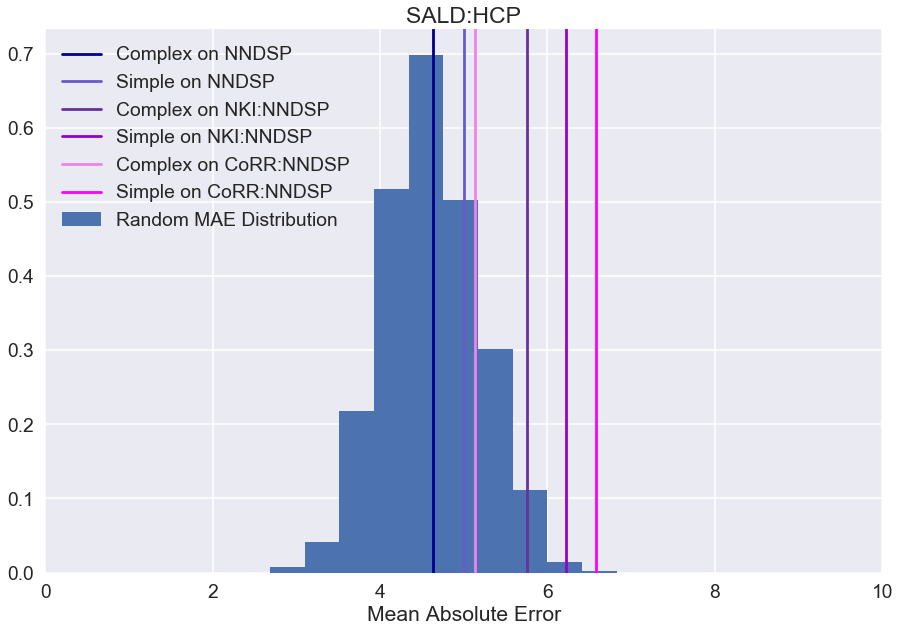

Percentile of  for Complex on NNDSP 52.5525525526
Percentile of  for Simple on NNDSP 75.6756756757
Percentile of  for Complex on NKI:NNDSP 97.0970970971
Percentile of  for Simple on NKI:NNDSP 99.5995995996
Percentile of  for Complex on CoRR:NNDSP 80.4804804805
Percentile of  for Simple on CoRR:NNDSP 99.8998998999


In [79]:
plot_rand_hist(sald2hcp_rand_ages, sald2hcp_mae, title='SALD:HCP', x_max=10,
              set_context='poster', fig_tuple=(15, 10), legend=True)
get_percentile(sald2hcp_rand_ages, sald2hcp_mae)